In [10]:
# Physics-Informed Neural Network for Periodic Advection Equation (Exercise 3)

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Use double precision for better accuracy
torch.set_default_dtype(torch.float64)

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Neural network model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 30),
            nn.Tanh(),
            nn.Linear(30, 30),
            nn.Tanh(),
            nn.Linear(30, 30),
            nn.Tanh(),
            nn.Linear(30, 30),
            nn.Tanh(),
            nn.Linear(30, 1)
        )

    def forward(self, x, t):
        xt = torch.cat((x, t), dim=1)
        return self.net(xt)

# Gradient function for autograd
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True, retain_graph=True)[0]

# Loss function for periodic advection problem
def loss_fn(model, x, t, a):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = grad(u, t)
    u_x = grad(u, x)

    # PDE residual
    f = u_t + a * u_x

    t_bc = torch.linspace(tmin, tmax, 100, device=device).unsqueeze(1)

    # Periodic boundary condition: u(-1, t) = u(1, t)
    bc = model(torch.full_like(t_bc, -1), t_bc) - model(torch.full_like(t_bc, 1), t_bc)

    # Initial condition: u(x, 0) = sin(2*pi*x)
    ic = model(x, torch.zeros_like(t)) - torch.sin(2 * np.pi * x)

    loss_pde = torch.mean(f**2)
    loss_bc = torch.mean(bc**2)
    loss_ic = torch.mean(ic**2)

    return loss_pde + 100.0 * loss_bc + 10.0 * loss_ic

# Training function
def train(model, epochs, optimizer, x, t, a):
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, x, t, a)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# Domain settings
a = 0.5
xmin, xmax, nx = -1, 1, 100
tmin, tmax, nt = 0, 1, 100

x = torch.linspace(xmin, xmax, nx, device=device).unsqueeze(1)
t = torch.linspace(tmin, tmax, nt, device=device).unsqueeze(1)
x_mesh, t_mesh = torch.meshgrid(x.flatten(), t.flatten(), indexing='ij')
x_mesh = x_mesh.reshape(-1, 1)
t_mesh = t_mesh.reshape(-1, 1)

# Initialize model and optimizer
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, 15000, optimizer, x_mesh, t_mesh, a)

# Prediction and visualization
model.eval()
with torch.no_grad():
    u_pred = model(x_mesh, t_mesh).cpu().numpy()

x_cpu = x.cpu().numpy().flatten()
t_cpu = t.cpu().numpy().flatten()
x_edges = np.append(x_cpu, x_cpu[-1] + (x_cpu[1] - x_cpu[0])) - (x_cpu[1] - x_cpu[0]) / 2
t_edges = np.append(t_cpu, t_cpu[-1] + (t_cpu[1] - t_cpu[0])) - (t_cpu[1] - t_cpu[0]) / 2


Using device: cpu
Epoch 0: Loss = 4.952457
Epoch 100: Loss = 4.915732
Epoch 200: Loss = 4.901327
Epoch 300: Loss = 4.896010
Epoch 400: Loss = 4.890844
Epoch 500: Loss = 4.882336
Epoch 600: Loss = 4.889750
Epoch 700: Loss = 4.857913
Epoch 800: Loss = 4.842003
Epoch 900: Loss = 4.837855
Epoch 1000: Loss = 4.832237
Epoch 1100: Loss = 4.829684
Epoch 1200: Loss = 4.823704
Epoch 1300: Loss = 4.818166
Epoch 1400: Loss = 4.816511
Epoch 1500: Loss = 4.810886
Epoch 1600: Loss = 4.803504
Epoch 1700: Loss = 4.803239
Epoch 1800: Loss = 4.781672
Epoch 1900: Loss = 4.727530
Epoch 2000: Loss = 4.661198
Epoch 2100: Loss = 4.618069
Epoch 2200: Loss = 3.816979
Epoch 2300: Loss = 3.064772
Epoch 2400: Loss = 2.674667
Epoch 2500: Loss = 2.351839
Epoch 2600: Loss = 2.281952
Epoch 2700: Loss = 2.179799
Epoch 2800: Loss = 2.109927
Epoch 2900: Loss = 1.983966
Epoch 3000: Loss = 1.957674
Epoch 3100: Loss = 1.676615
Epoch 3200: Loss = 1.451767
Epoch 3300: Loss = 1.252852
Epoch 3400: Loss = 1.000566
Epoch 3500: Lo

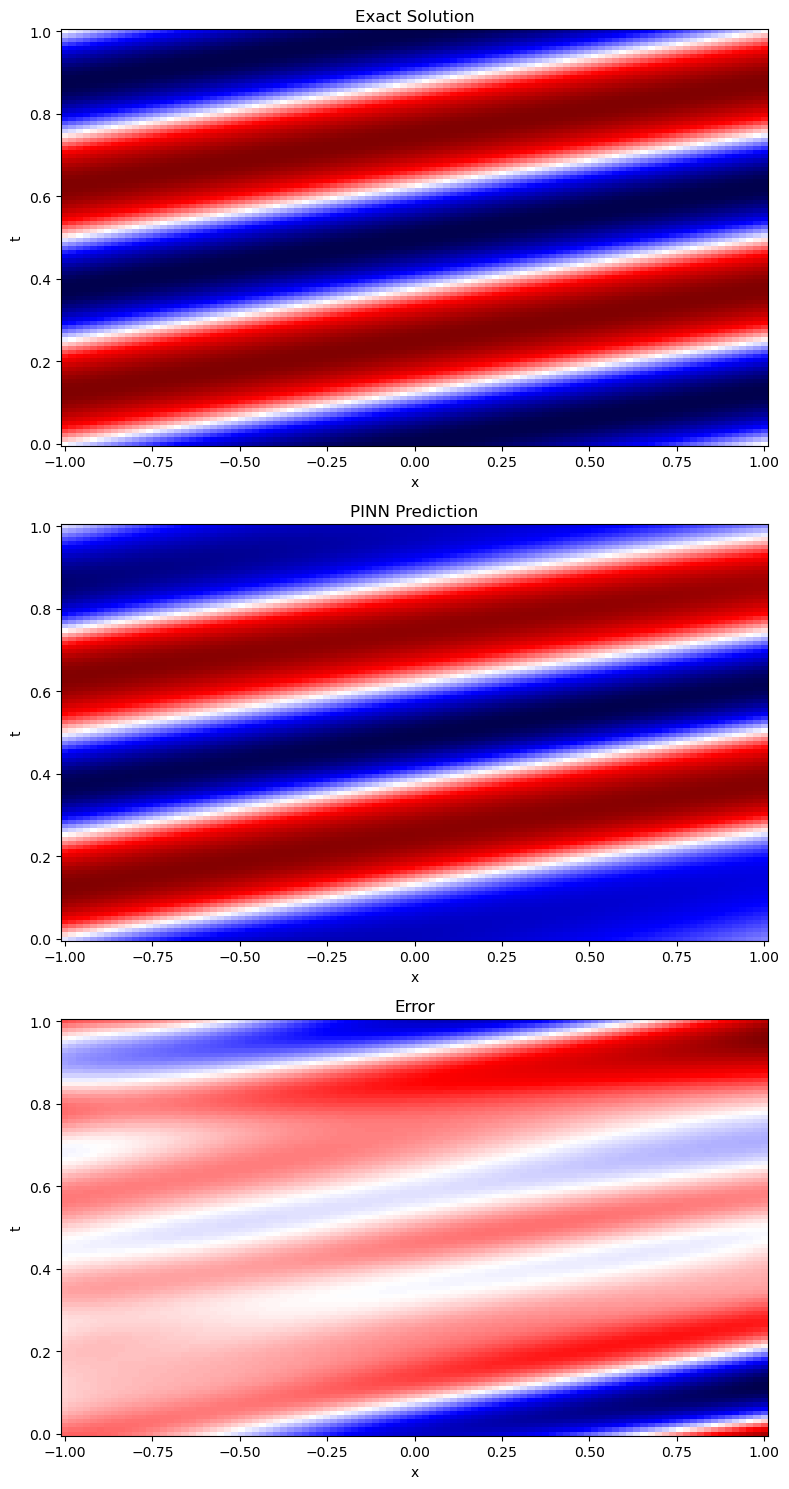

In [11]:

# Exact solution
u_exact = np.sin(2 * np.pi * (x_mesh.detach().cpu().numpy() - a * t_mesh.detach().cpu().numpy()))


# Error
error = u_exact - u_pred

# Plot
fig, axes = plt.subplots(3, 1, figsize=(8, 15))

axes[0].set_title("Exact Solution")
axes[0].pcolormesh(x_edges, t_edges, u_exact.reshape(nx, nt), cmap='seismic', shading='auto')

axes[1].set_title("PINN Prediction")
axes[1].pcolormesh(x_edges, t_edges, u_pred.reshape(nx, nt), cmap='seismic', shading='auto')

axes[2].set_title("Error")
axes[2].pcolormesh(x_edges, t_edges, error.reshape(nx, nt), cmap='seismic', shading='auto')

for ax in axes:
    ax.set_xlabel('x')
    ax.set_ylabel('t')

plt.tight_layout()
plt.show()


In [13]:
l2_error = np.mean((u_exact - u_pred)**2)
print(f"L2 Error (MSE): {l2_error:.6e}")


L2 Error (MSE): 1.082847e-02


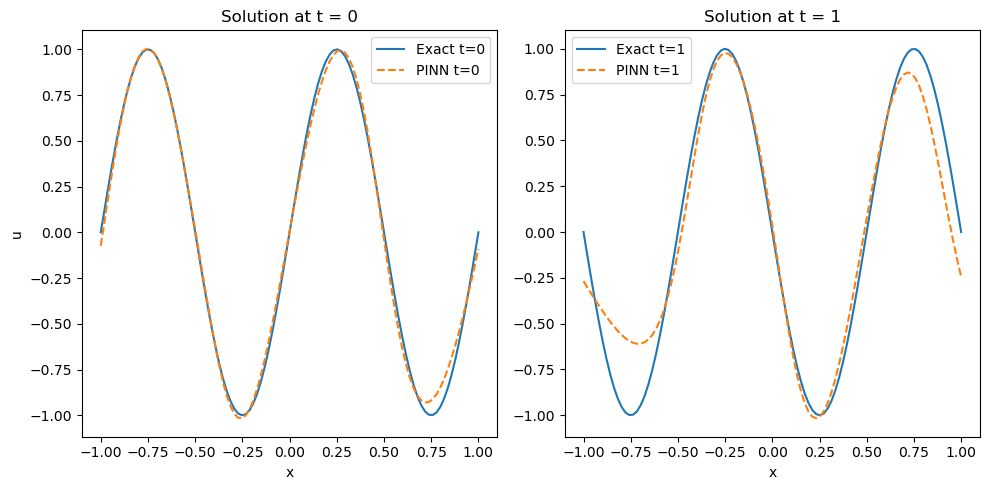

In [14]:
# Prepare spatial grid x for t=0 and t=tmax
x_plot = torch.linspace(xmin, xmax, nx, device=device).unsqueeze(1)

# Time tensors
t0 = torch.zeros_like(x_plot)
t_end = torch.full_like(x_plot, tmax)

# Predict at t=0 and t=tmax
with torch.no_grad():
    u_t0 = model(x_plot, t0).cpu().numpy()
    u_tend = model(x_plot, t_end).cpu().numpy()

# Exact solutions
x_np = x_plot.cpu().numpy()
u_exact_t0 = np.sin(2 * np.pi * x_np)
u_exact_tend = np.sin(2 * np.pi * (x_np - a * tmax))

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x_np, u_exact_t0, label='Exact t=0')
plt.plot(x_np, u_t0, '--', label='PINN t=0')
plt.title("Solution at t = 0")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_np, u_exact_tend, label=f'Exact t={tmax}')
plt.plot(x_np, u_tend, '--', label=f'PINN t={tmax}')
plt.title(f"Solution at t = {tmax}")
plt.xlabel("x")
plt.legend()

plt.tight_layout()
plt.show()
